In [1]:
# import libs
import torch, timm
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms as T
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob(f"{root}/*/*"))
        self.transform = transform
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        label_name = os.path.basename(os.path.dirname(path))
        label = self.class_to_idx[label_name]
        if self.transform:
            img = self.transform(img)
        return img, label


In [3]:
root = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image"  # change if needed

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(root, transform)
n_total = len(dataset)
n_train = int(0.9 * n_total)
n_val = int(0.05 * n_total)
n_test = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)
test_dl  = DataLoader(test_ds, batch_size=1)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 3127, Val: 173, Test: 175


In [4]:
# Creating rexnet model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model("rexnet_150", pretrained=True, num_classes=len(dataset.class_names))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

In [5]:
# training loop with accuracy, f1 and loss
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

for epoch in range(5):
    model.train()
    running_loss, correct = 0, 0
    all_preds, all_labels = [], []

    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_dl)
    train_acc = correct / len(train_ds)
    train_f1 = f1_score(all_labels, all_preds, average="macro")

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_dl)
    val_acc = val_correct / len(val_ds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.3f}, Train Acc={train_acc:.3f}, Train F1={train_f1:.3f}, "
          f"Val Loss={val_loss:.3f}, Val Acc={val_acc:.3f}, Val F1={val_f1:.3f}")


Epoch 1: Train Loss=0.595, Train Acc=0.859, Train F1=0.861, Val Loss=0.241, Val Acc=0.908, Val F1=0.912
Epoch 2: Train Loss=0.103, Train Acc=0.962, Train F1=0.963, Val Loss=0.381, Val Acc=0.913, Val F1=0.917
Epoch 3: Train Loss=0.058, Train Acc=0.981, Train F1=0.981, Val Loss=0.449, Val Acc=0.908, Val F1=0.913
Epoch 4: Train Loss=0.037, Train Acc=0.987, Train F1=0.987, Val Loss=0.386, Val Acc=0.908, Val F1=0.912
Epoch 5: Train Loss=0.035, Train Acc=0.988, Train F1=0.988, Val Loss=0.578, Val Acc=0.908, Val F1=0.911


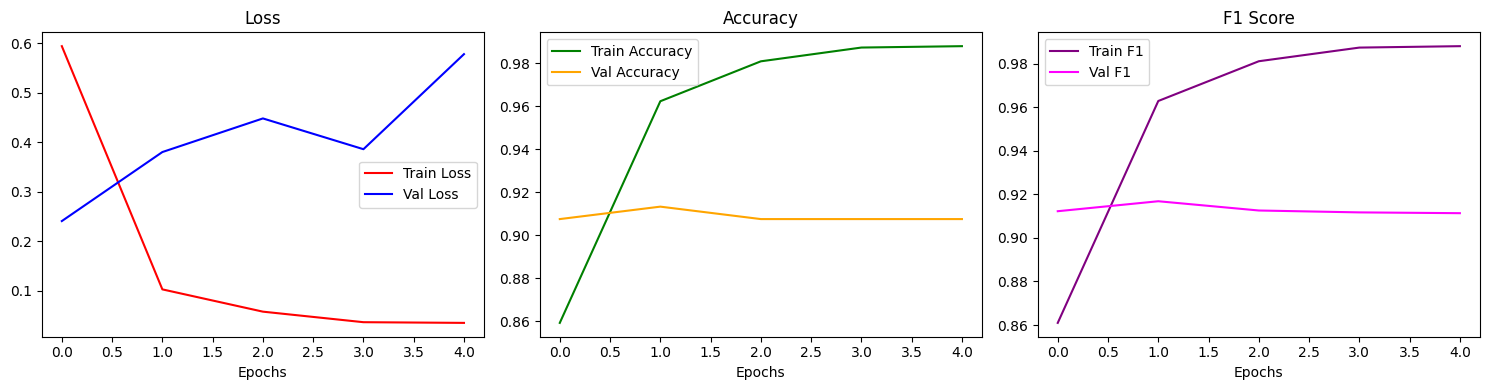

In [6]:
# Plots for loss,accuracy and f1 score
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss", color="red")
plt.plot(val_losses, label="Val Loss", color="blue")
plt.title("Loss"); plt.xlabel("Epochs"); plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.plot(val_accuracies, label="Val Accuracy", color="orange")
plt.title("Accuracy"); plt.xlabel("Epochs"); plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label="Train F1", color="purple")
plt.plot(val_f1s, label="Val F1", color="magenta")
plt.title("F1 Score"); plt.xlabel("Epochs"); plt.legend()

plt.tight_layout()
plt.show()


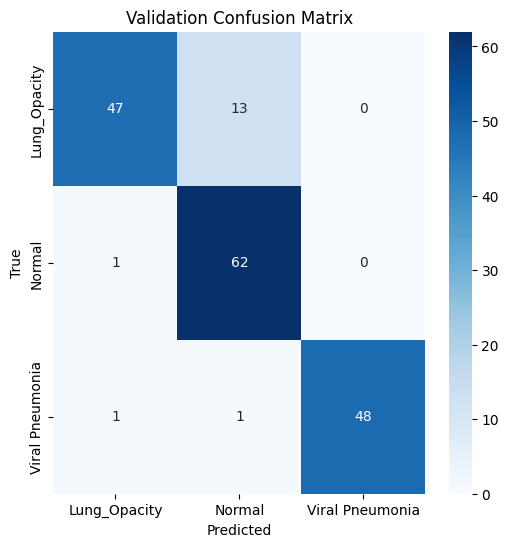

In [7]:
# Confusion matrix on validation data
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

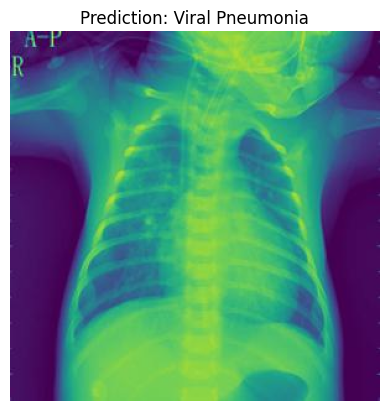

'Viral Pneumonia'

In [8]:
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
        pred = out.argmax(1).item()
    plt.imshow(img)
    plt.title(f"Prediction: {dataset.class_names[pred]}")
    plt.axis("off")
    plt.show()
    return dataset.class_names[pred]


predict_image("/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Viral Pneumonia/1001.jpg")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


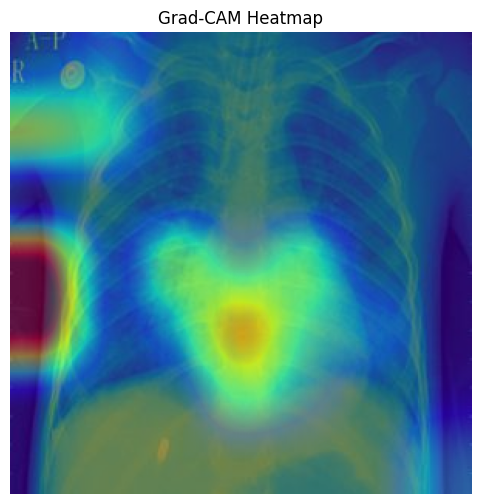

In [9]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        layer = dict([*self.model.named_modules()])[self.target_layer]
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(1).item()
        output[:, class_idx].backward()
        grads = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (grads * self.activations).sum(dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam / cam.max()
        return cam.detach().cpu().numpy()

def show_gradcam(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    gradcam = GradCAM(model, target_layer="features.16.conv")  # last conv layer
    cam = gradcam.generate(input_tensor)

    cam = cam.squeeze()  # (H, W)
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # normalize
    cam = np.uint8(255 * cam)
    cam_resized = np.array(Image.fromarray(cam).resize(img.size))

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(cam_resized, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()

show_gradcam("/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Viral Pneumonia/1.jpg")


In [10]:
# Save only the model parameters
torch.save(model.state_dict(), "model.pth")
print("Model saved successfully!")
# Save the entire model including architecture
torch.save(model, "full_model.pth")
print("Full model saved successfully!")


Model saved successfully!


AttributeError: Can't pickle local object 'GradCAM.hook_layers.<locals>.backward_hook'